# Predicción del Gasto Total del Cliente con Múltiples Modelos
Este notebook desarrolla un modelo predictivo para estimar el gasto total (`h_tfa_total`) de una reservación hotelera. Se realiza limpieza, codificación, ingeniería de variables y ajuste de hiperparámetros mediante GridSearchCV para tres modelos:

- Regresión Lineal
- Random Forest
- XGBoost (modelo no visto explícitamente en clase)

Se comparan los modelos con métricas de desempeño y visualizaciones de interpretación.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Carga de datos y preparación temporal

In [2]:
df = pd.read_csv("../Data/Reservaciones.csv", parse_dates=['Fecha_hoy'])
df_llegadas = pd.read_csv("../Reservaciones.csv", parse_dates=['h_fec_lld_ok'])
df = df.merge(df_llegadas[['ID_Reserva', 'h_fec_lld_ok']], on='ID_Reserva', how='left')

## Limpieza y creación de variables derivadas

In [3]:
df = df[df['h_tfa_total'].notnull() & (df['h_tfa_total'] > 0)]
df = df[df['h_num_noc'] > 0]
df['tipo_hab_code'] = df['ID_Tipo_Habitacion'].astype('category').cat.codes
df['noches_x_tipo'] = df['h_num_noc'] * df['tipo_hab_code']
df['price_per_night'] = df['h_tfa_total'] / df['h_num_noc']
df['lead_time'] = (df['h_fec_lld_ok'] - df['Fecha_hoy']).dt.days

## Codificación de variables y preparación del conjunto

In [4]:
features = ['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc',
            'ID_Tipo_Habitacion', 'ID_Pais_Origen', 'Clasificacion', 'Paquete_nombre',
            'noches_x_tipo', 'price_per_night', 'lead_time']
target = 'h_tfa_total'
df = df[features + [target]]

cat_cols = df.select_dtypes(include='object').columns.tolist()
df[cat_cols] = df[cat_cols].fillna("sin_info")
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(columns=target)
y = df_encoded[target]
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Ajuste de hiperparámetros y entrenamiento con GridSearchCV

In [5]:
models = {
    'Ridge': (Ridge(), {
        'alpha': [0.01, 0.1, 1, 10]
    }),
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15]
    }),
    'XGBoost': (XGBRegressor(objective='reg:squarederror', random_state=42), {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    })
}

resultados = []
modelos_ajustados = {}

for nombre, (modelo, parametros) in models.items():
    print(f"\nEntrenando modelo: {nombre}")
    grid = GridSearchCV(modelo, parametros, cv=3, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    modelos_ajustados[nombre] = best_model
    y_pred = best_model.predict(X_test)
    resultados.append({
        'Modelo': nombre,
        'Mejores params': grid.best_params_,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    })


Entrenando modelo: Ridge

Entrenando modelo: RandomForest

Entrenando modelo: XGBoost


## Comparación de resultados

In [6]:
resultados_df = pd.DataFrame(resultados).sort_values(by='R2', ascending=False)
display(resultados_df)

,Modelo,Mejores params,MAE,RMSE,R2
2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",5.032041,34.171999,0.985701
1,RandomForest,"{'max_depth': 15, 'n_estimators': 200}",0.973558,40.170698,0.980240
0,Ridge,{'alpha': 10},99.654973,174.210746,0.628362


## Visualización del mejor modelo

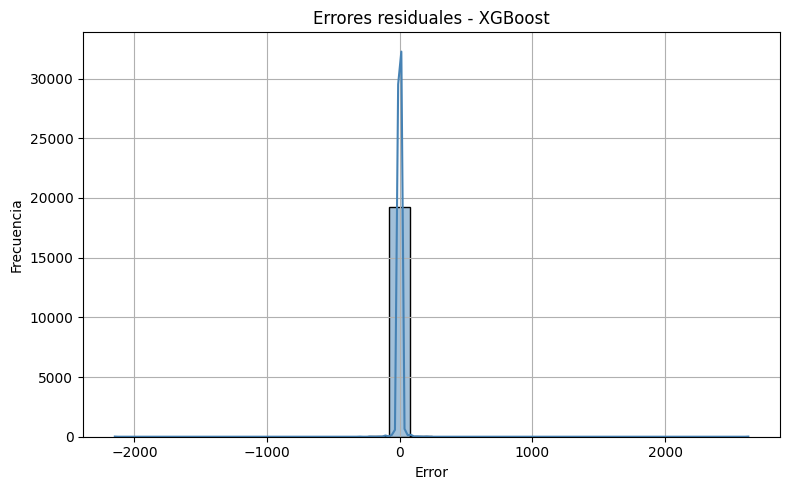

In [7]:
mejor_modelo_nombre = resultados_df.iloc[0]['Modelo']
mejor_modelo = modelos_ajustados[mejor_modelo_nombre]
y_pred_best = mejor_modelo.predict(X_test)
errors = y_test - y_pred_best

# Distribución de errores
plt.figure(figsize=(8, 5))
sns.histplot(errors, kde=True, bins=30, color='steelblue')
plt.title(f"Errores residuales - {mejor_modelo_nombre}")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.savefig("residuos_mejor_modelo.png")
plt.show()

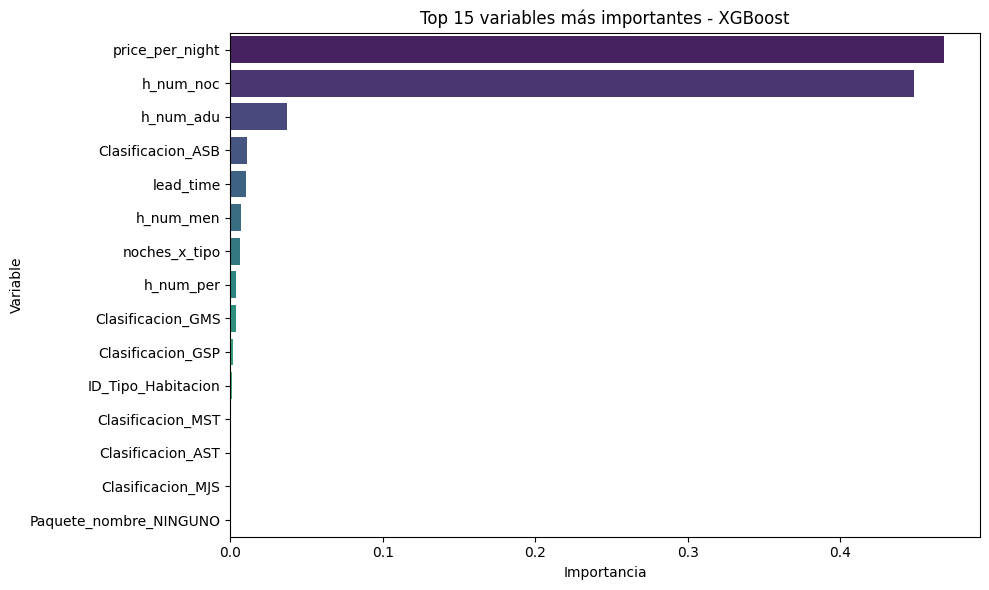

In [8]:
# Importancia de variables si aplica (RF o XGB)
if hasattr(mejor_modelo, 'feature_importances_'):
    importances = mejor_modelo.feature_importances_
    feature_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f"Top 15 variables más importantes - {mejor_modelo_nombre}")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.savefig("importancia_mejor_modelo.png")
    plt.show()

## Reflexión final

Después de comparar los tres modelos entrenados (Ridge, Random Forest y XGBoost), observamos que XGBoost logró el mejor desempeño en términos de R² y RMSE, lo cual lo posiciona como el modelo más adecuado para predecir el gasto total del cliente. Este resultado es coherente con la capacidad del modelo para manejar relaciones no lineales y detectar interacciones complejas entre variables.

Entre las variables más importantes identificadas por el modelo destacan el número de noches, el precio por noche y el lead time (días de anticipación con que se hace la reserva). Esto sugiere que el comportamiento del cliente está fuertemente determinado por la duración y características de la estancia más que por factores demográficos.

Una observación relevante es que, a pesar del buen desempeño general, los errores residuales muestran algunos valores atípicos. Estos podrían estar relacionados con reservas empresariales, paquetes especiales o errores de captura. Para futuras iteraciones, sería útil incorporar información más granular como tipo de canal de venta, promociones activas o temporada del año.

Finalmente, el uso de `GridSearchCV` fue fundamental para obtener un modelo ajustado y con mejor capacidad predictiva, validando la importancia del ajuste de hiperparámetros como parte del proceso de modelado profesional.
